In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sequence.kernel.timeline import Timeline
from sequence.components.photon import Photon
from sequence.components.polarization_analyzer import PolarizationAnalyzer  # Replace with actual import

from sequence.components.spdc_source_node import SpdcSourceNode
from sequence.topology.node import Node
from sequence.components.optical_channel import QuantumChannel
from numpy import radians
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [44]:
def count_coincidences(tA, tB, window=1e3):
    ta = np.sort(np.array(tA))
    tb = np.sort(np.array(tB))
    a_idx = b_idx = count = 0
    while a_idx < len(ta) and b_idx < len(tb):
        diff = ta[a_idx] - tb[b_idx]
        if abs(diff) <= window:
            count += 1
            a_idx += 1
            b_idx += 1
        elif diff < -window:
            a_idx += 1
        else:
            b_idx += 1
    return count

def test_polarization_analyzer_coincidences(angle_rad_A, angle_rad_B, num_pulses=100000):
    tl = Timeline()
    # Setup source
    source = SpdcSourceNode("source", tl, config={
        "frequency": 1e6,
        "mean_photon_num": 0.1,
        "bell_state": "psi+",
    })

    # Two analyzers with configurable HWP angles
    analyzer_A = PolarizationAnalyzer("analyzer_A", tl, angle=angle_rad_A, which="signal")
    analyzer_B = PolarizationAnalyzer("analyzer_B", tl, angle=angle_rad_B, which="idler")

    # Quantum channels
    qc_A = QuantumChannel("qc_A", tl, distance=30e3, attenuation=0)
    qc_B = QuantumChannel("qc_B", tl, distance=30e3, attenuation=0)
    qc_A.set_ends(source, analyzer_A.name)
    qc_B.set_ends(source, analyzer_B.name)
    

    # Run
    tl.init()
    source.spdc.emit(num_pulses=num_pulses)
    tl.run()

    counts_A = analyzer_A.get_detection_counts()
    counts_B = analyzer_B.get_detection_counts()

    hh = count_coincidences(counts_A[0], counts_B[0])
    vv = count_coincidences(counts_A[1], counts_B[1])
    hv = count_coincidences(counts_A[0], counts_B[1])
    vh = count_coincidences(counts_A[1], counts_B[0])
    return hh, vv, hv, vh



def plot_coincidences(results, angles, coincidence_type="hh"):
    """
    Plot smooth sinusoidal curves for a given coincidence type from results.
    
    Args:
        results: dict with format {"angle°": {"hh": [...], "vv": [...], "hv": [...], "vh": [...]}, ...}
        angles: list or numpy array of angles (in radians)
        coincidence_type: one of "hh", "vv", "hv", "vh"
    """
    x = np.degrees(angles)

    for label, data in results.items():
        y = data[coincidence_type]
        
        # Interpolate for smooth curve
        x_smooth = np.linspace(x.min(), x.max(), 500)
        try:
            spline = make_interp_spline(x, y, k=3)
            y_smooth = spline(x_smooth)
        except ValueError as e:
            print(f"[Warning] Skipping {label} due to interpolation error: {e}")
            continue

        # Plot
        plt.plot(x_smooth, y_smooth, label=f"HWP B fixed at {label}")
        plt.scatter(x, y, marker='x', alpha=0.4)  # show raw points

    plt.xlabel("HWP A angle (degrees)")
    plt.ylabel(f"Coincidence Count ({coincidence_type.upper()})")
    plt.title(f"Polarization Entanglement: {coincidence_type.upper()} Fringes")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()





In [42]:
angles = np.linspace(0, np.pi , 20)

fixed_angles = [-22.5, 0, 22.5, 45]
results = {}

for fixed in fixed_angles:
    fixed_rad = radians(fixed)
    coincidences = {"hh": [], "vv": [], "hv": [], "vh": []} 
    for angle in angles:
        hh, vv, hv, vh = test_polarization_analyzer_coincidences(angle, fixed_rad)  # Fix B, rotate A
        coincidences["hh"].append(hh)
        coincidences["vv"].append(vv)
        coincidences["hv"].append(hv)
        coincidences["vh"].append(vh)
    results[f"{fixed}°"] = coincidences
    

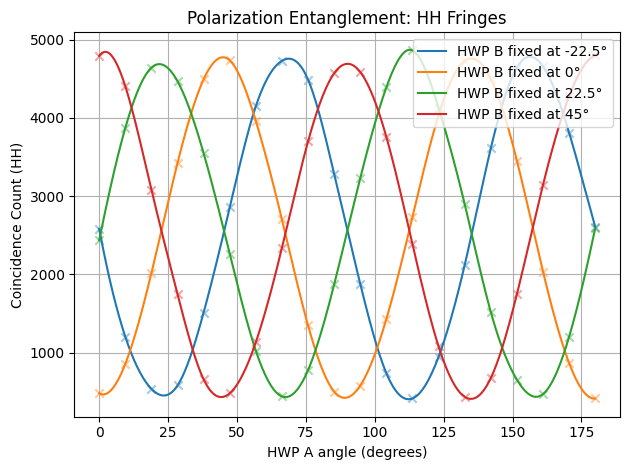

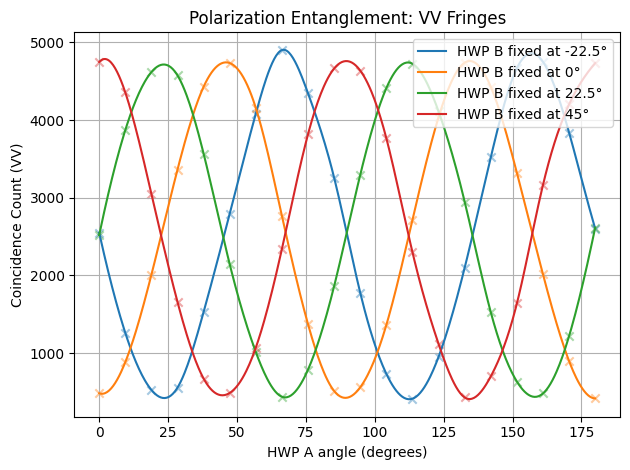

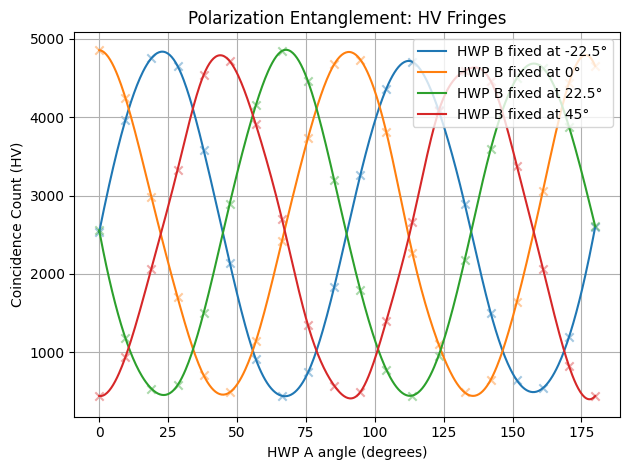

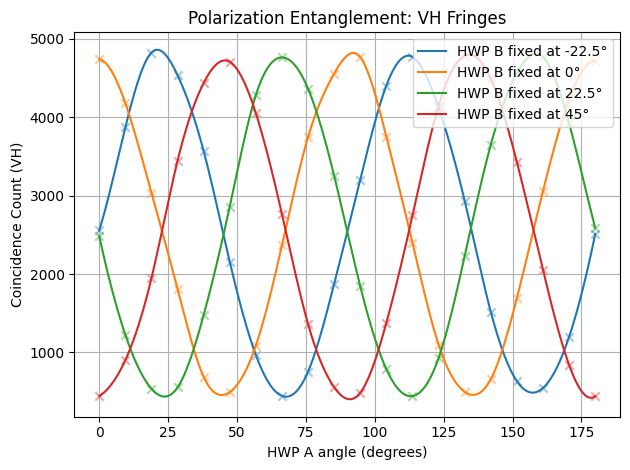

In [47]:
plot_coincidences(results, angles, coincidence_type="hh")
plot_coincidences(results, angles, coincidence_type="vv")
plot_coincidences(results, angles, coincidence_type="hv")
plot_coincidences(results, angles, coincidence_type="vh")

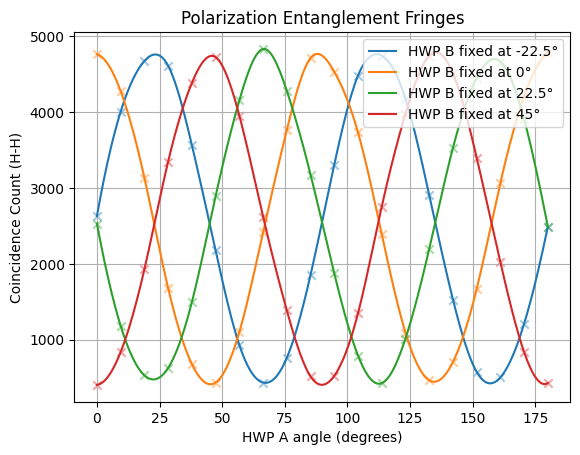

In [ ]:
angles = np.linspace(0, np.pi , 20)

fixed_angles = [-22.5, 0, 22.5, 45]
coincidences = {"hh": [], "vv": [], "hv": [], "vh": []}
results = {f"{angle}°": coincidences for angle in fixed_angles}
for fixed in fixed_angles:
    fixed_rad = radians(fixed)
    for angle in angles:
        hh, vv, hv, vh = test_polarization_analyzer_coincidences(angle, fixed_rad)  # Fix B, rotate A
        coincidences["hh"].append(hh)
        coincidences["vv"].append(vv)
        coincidences["hv"].append(hv)
        coincidences["vh"].append(vh)
        for pol in results[f"{fixed}°"]:
            results[f"{fixed}°"][pol].append(coincidences[pol])
    #results[f"{fixed}°"].append(coincidences)
    coincidences = []  # Reset for next fixed angle

from scipy.interpolate import make_interp_spline

# === Plot ===
for label, data in results.items():
    x = np.degrees(angles)
    y = data[0]

    # Interpolate
    x_smooth = np.linspace(x.min(), x.max(), 500)  # More points
    spline = make_interp_spline(x, y, k=3)         # Cubic spline
    y_smooth = spline(x_smooth)

    # Plot smooth curve
    plt.plot(x_smooth, y_smooth, label=f"HWP B fixed at {label}")
    plt.scatter(x, y, marker='x', alpha=0.4)  # Optional: show original points faintly

plt.xlabel("HWP A angle (degrees)")
plt.ylabel("Coincidence Count (H-H)")
plt.title("Polarization Entanglement Fringes")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()





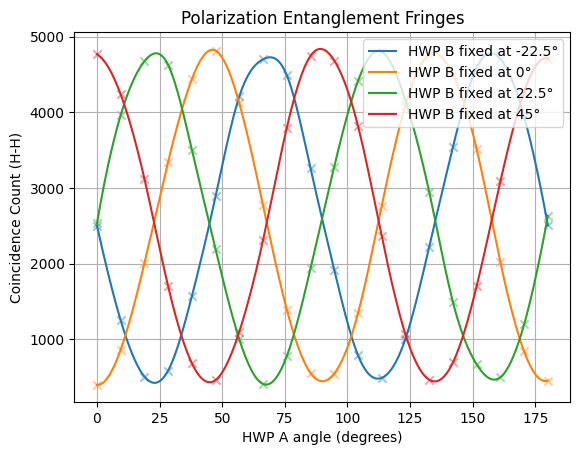

In [12]:
from scipy.interpolate import make_interp_spline

# === Plot ===
for label, data in results.items():
    x = np.degrees(angles)
    y = data[0]

    # Interpolate
    x_smooth = np.linspace(x.min(), x.max(), 500)  # More points
    spline = make_interp_spline(x, y, k=3)         # Cubic spline
    y_smooth = spline(x_smooth)

    # Plot smooth curve
    plt.plot(x_smooth, y_smooth, label=f"HWP B fixed at {label}")
    plt.scatter(x, y, marker='x', alpha=0.4)  # Optional: show original points faintly

plt.xlabel("HWP A angle (degrees)")
plt.ylabel("Coincidence Count (H-H)")
plt.title("Polarization Entanglement Fringes")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
